# **Tutorial 8: Comparing Satellite Products With In Situ Data**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google Deepmind

# **Tutorial Objectives**

In this tutorial, our primary focus will be on the 'Verification of Satellite Data'. Building on our previous modules where we explored various climate applications of satellite data, we will now delve into the critical task of assessing the quality and reliability of such data.

By the end of this tutorial, you will learn how to use land-based observations to validate satellite climate data. In this process you will:

*  Learn how to access the gridded climate data derived from station observations from AWS.
*  Learn how to convert monthly total values to a daily rate.
*  Learn how to correctly evaluate satellite data against land-based observations.

# **Setup**

In [1]:
# !pip install s3fs --quiet

# properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [2]:
# imports
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pooch
import os
import tempfile
import boto3
import botocore
from scipy import stats

In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [4]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

In [5]:
# helper functions

def pooch_load(filelocation='',filename=''):
    shared_location='/home/jovyan/shared/data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename))

    return file

# **Section 1: Evaluating Satellite Data with Observations**



Satellite data is frequently cross-verified against observations deemed reliable to evaluate its quality. Station-based observations and derived data are typically regarded as a reliable reference. When it comes to oceanic data, measurements taken by ships, buoys, drifters, or gliders are often used as a benchmark to assess the quality of satellite data.

In this tutorial, we will be using the nClimGrid dataset, a gridded climate dataset produced by NOAA. This dataset provides daily and monthly temperature and precipitation data, leveraging all available station observations. However, it's important to note that this dataset is exclusive to the United States. We have selected this dataset due to its public availability on AWS. You are encouraged to explore other station data for the evaluation of satellite data in your projects.

## **Section 1.1: Accesing nClimGrid - a station based gridded climate data**

The nClimGrid-monthly dataset is a gridded dataset derived from spatially interpolating data from the [Global Historical Climatology Network (GHCN)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily). The dataset includes monthly precipitation, monthly temperature average, monthly temperature maximum and monthly temperature minimum.  The dataset provides monthly values in a approximate 5x5 km lat/lon grid for the Continental United States. Data is available from 1895 to the present via NOAA NCEI or AWS. We will be accessing the data via AWS directly.


In [6]:
# connect to the AWS S3 bucket for the nClimGrid Monthly Precipitation data

# read in the monthly precipitation data from nClimGrid on AWS
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

file_nclimgrid = 'noaa-nclimgrid-monthly-pds/nclimgrid_prcp.nc'
ds = xr.open_dataset(pooch_load(filelocation='http://s3.amazonaws.com/'+file_nclimgrid,filename=file_nclimgrid))
ds

<xarray.Dataset>
Dimensions:  (time: 1541, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2023-05-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    prcp     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2023-01-06 09:27:45.962383
    date_modified:             2023-01-06 09:27:45.962559
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

The nClimGrid dataset is available from `1895-01-01` until present. Since our GPCP data is only available between `1979-01-01` and `2022-12-01`, extract only the data from that time period from the nClimGrid monthly data.

In [7]:
prcp_obs = ds.sel(time=slice('1979-01-01', '2022-12-31'))
prcp_obs

<xarray.Dataset>
Dimensions:  (time: 528, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    prcp     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2023-01-06 09:27:45.962383
    date_modified:             2023-01-06 09:27:45.962559
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

From the information about the precipitation data from nClimGird monthly dataset, we know it is the monthly total precipitation, which is the total amount of rainfall that a location receives for the entire month with the unit of `millimeter`.

In [8]:
prcp_obs.prcp

<xarray.DataArray 'prcp' (time: 528, lat: 596, lon: 1385)>
[435842880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Attributes:
    references:     GHCN-Monthly Version 3 (Vose et al. 2011), NCEI/NOAA, htt...
    long_name:      Precipitation, monthly total
    standard_name:  precipitation_amount
    units:          millimeter
    valid_min:      0.0
    valid_max:      2000.0

However, the GPCP satellite precipitation variable is the daily precipitation rate with the unit of `mm/day`. This variable quantifies the average amount of precipitation in a day for a given location in a month. 

To convert from the total amount to the precipitation rate, we just need to divide the amount by the number of days within a month (e.g., 31 days for January). We can use `.days_in_month` to achieve that.

In [9]:
# calculate precipitation rate from nClimGrid
obs_rate = prcp_obs.prcp/prcp_obs.time.dt.days_in_month
obs_rate

<xarray.DataArray (time: 528, lat: 596, lon: 1385)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02

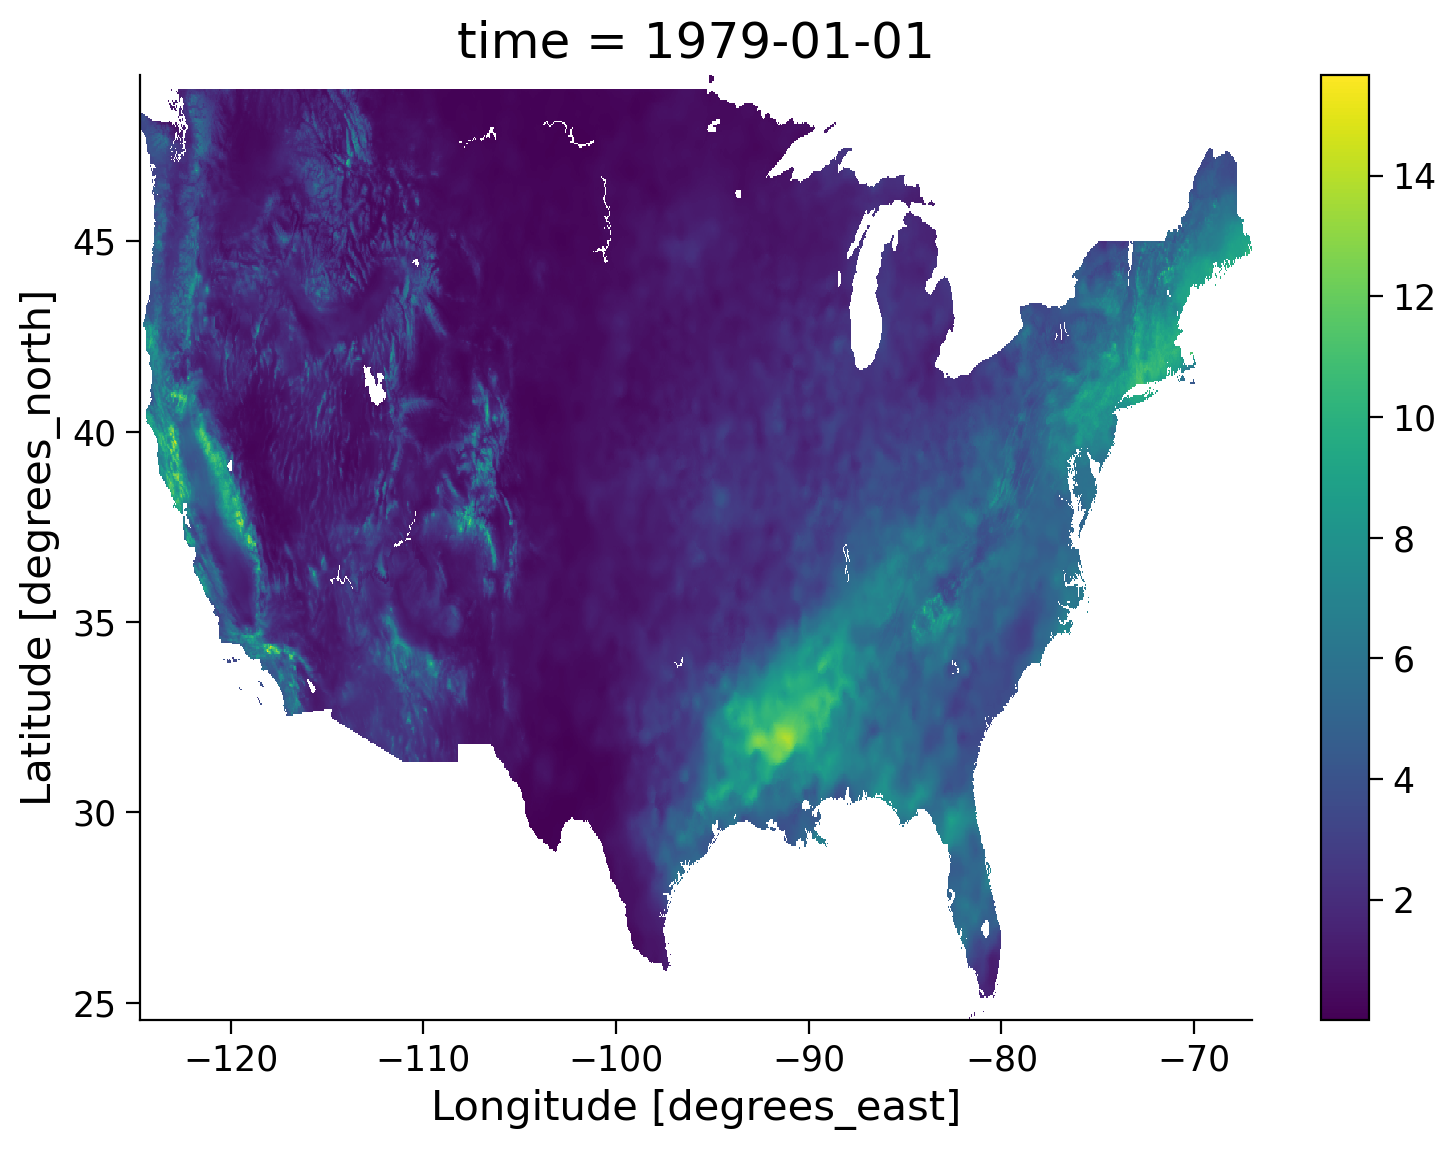

In [10]:
# generate the map of precipitation rate from nClimGrid monthly data
obs_rate[0].plot()

In this quick map, we can see the value range of the precipitation rate appears to be reasonable compared to the GPCP monthly precipitation CDR data (0-20 mm/day).

## **Section 1.2: Read GPCP Monthly Precipitation Data**

Now we are ready to compare our land-based observations to the monthly GPCP satellite from AWS public data catalog.

In [11]:
# get the list of all data files in the AWS S3 bucket
fs = s3fs.S3FileSystem(anon=True)
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

# open connection to all data files
file_ob=[pooch_load(filelocation='http://s3.amazonaws.com/'+file,filename=file) for file in file_location]

# open all the monthly data files and concatenate them along the time dimension.
# this process will take ~ 1 minute to complete due to the number of data files.
ds_gpcp = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds_gpcp

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 531, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-03-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In [12]:
# get the GPCP precipitation rate
prcp_sat = ds_gpcp.precip
prcp_sat

<xarray.DataArray 'precip' (time: 531, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(531, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-03-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

## **Section 1.3: Spatial Pattern**

Now, let's take a quick look at the spatial pattern between these two datasets for a selected month (e.g., 1979-01-01).

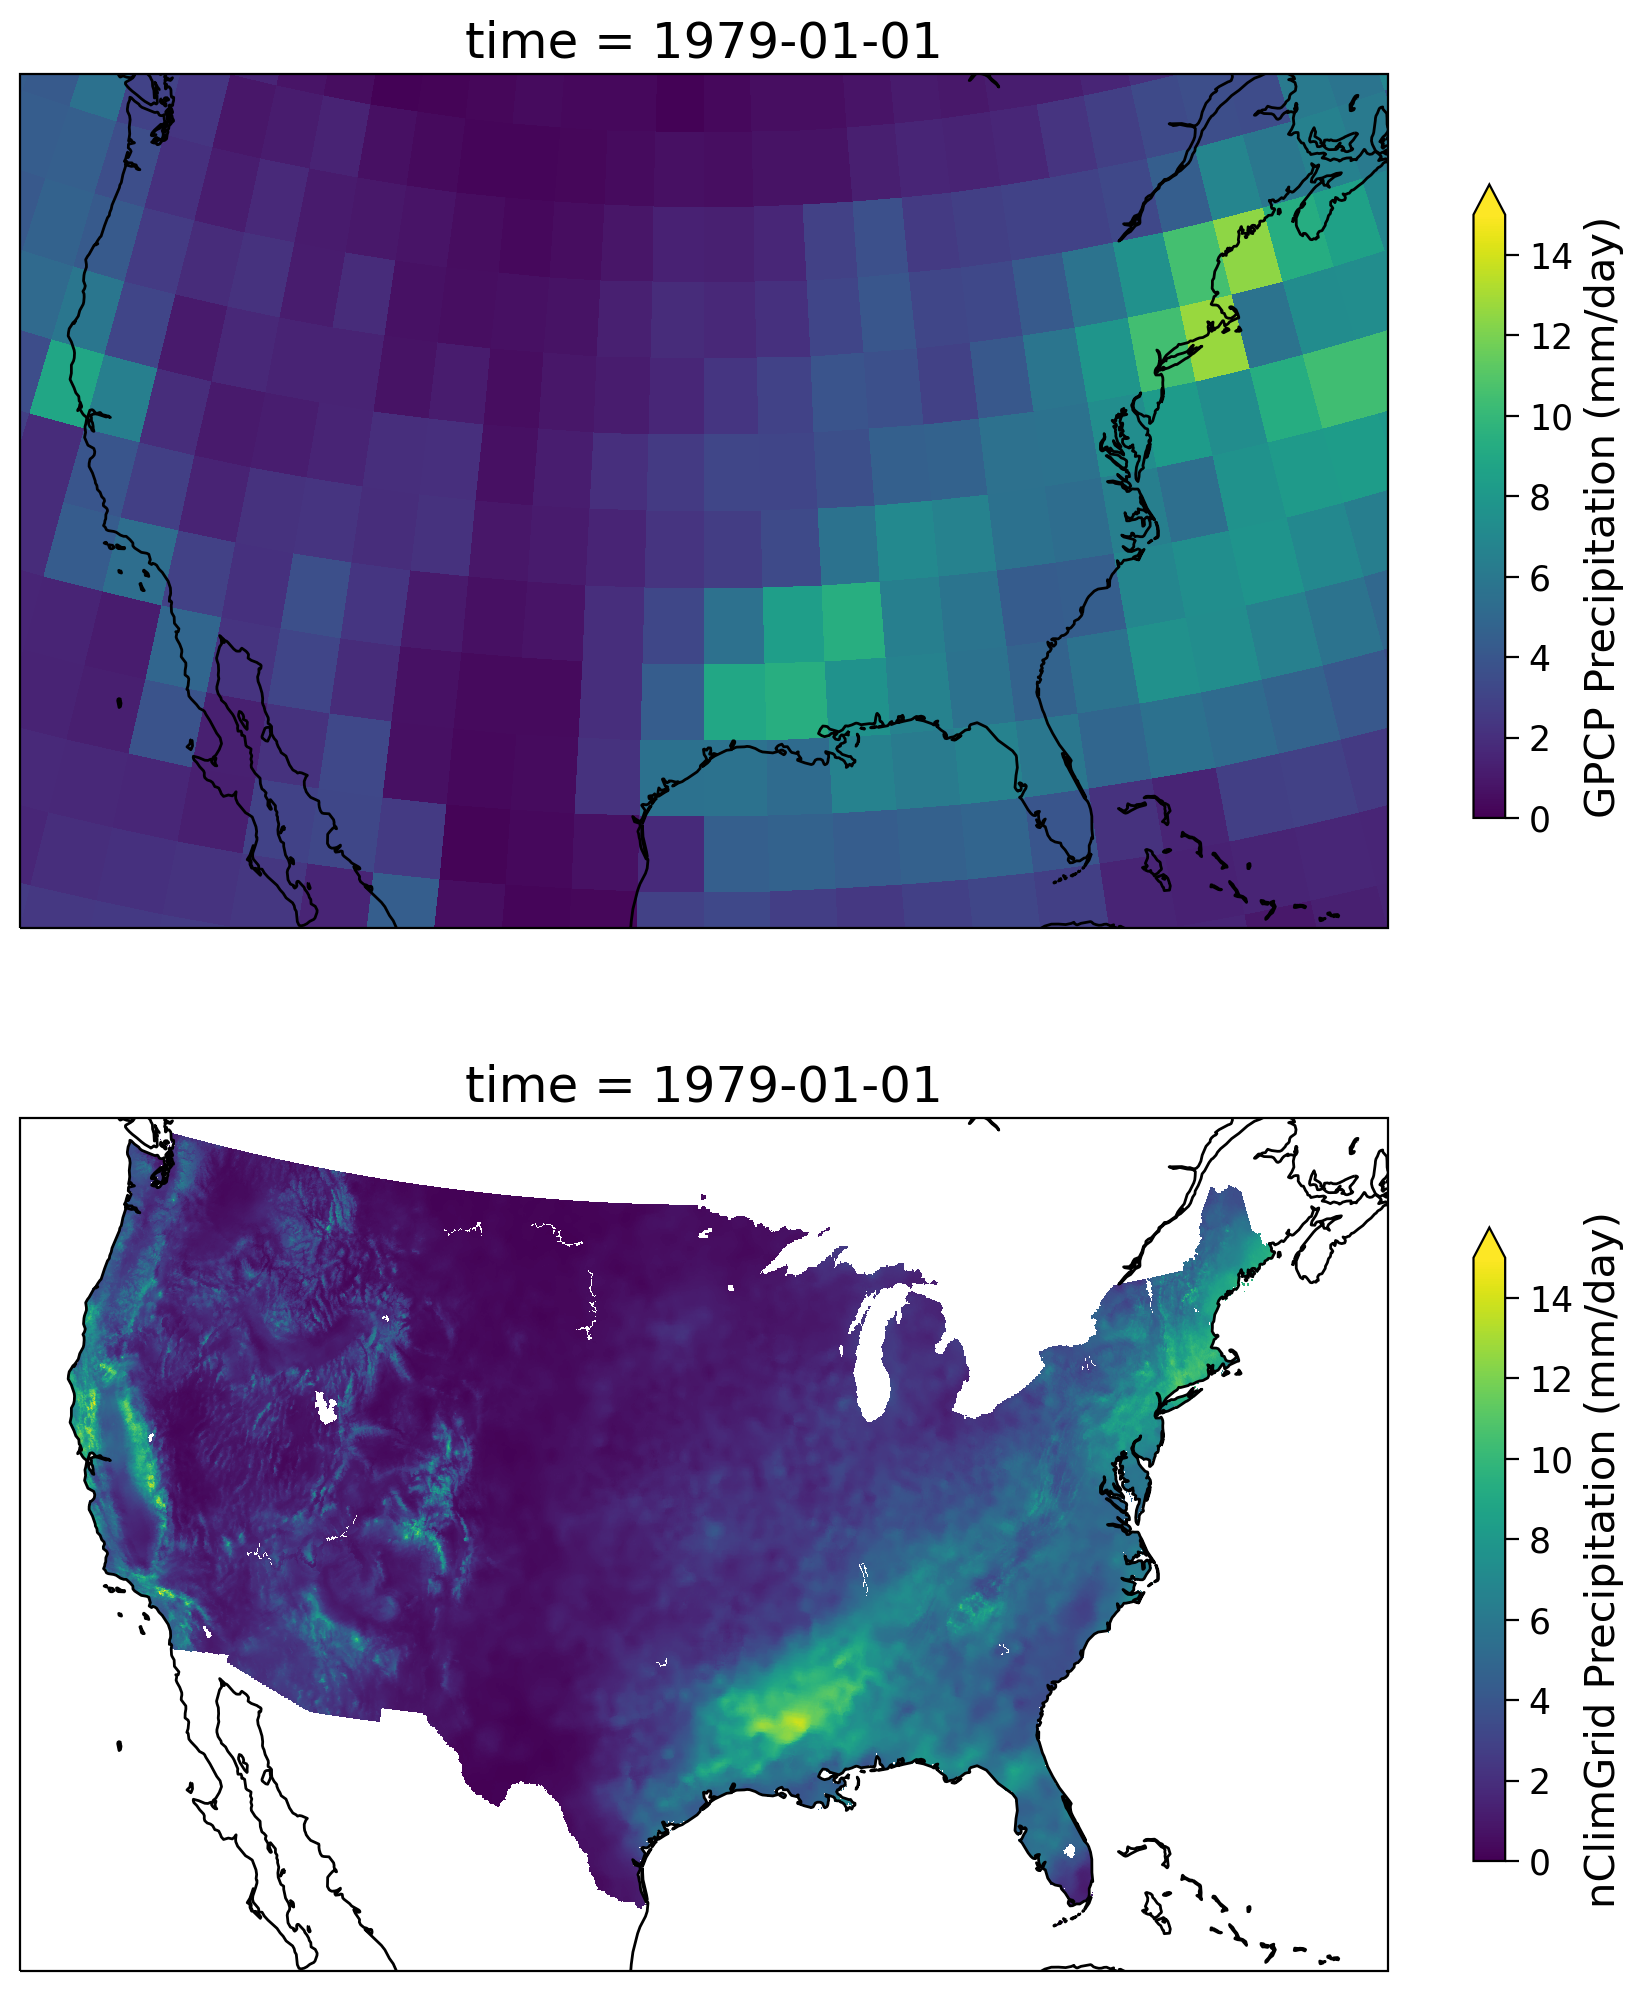

In [13]:
# set up the geographical region for continental US
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 21, 50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# extract sat and obs data for the month of 1979-01-01
sat = prcp_sat.sel(time='1979-01-01')
obs = obs_rate.sel(time='1979-01-01')

# initate plot for North America using two suplots
fig,axs = plt.subplots(2, subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                       figsize=(9,12), sharex=True, sharey=True)
axs[0].set_extent(extent)
axs[0].coastlines()
axs[0].set_title('GPCP Monthly')
sat.plot(ax=axs[0], transform=ccrs.PlateCarree(),
         vmin = 0, vmax = 15,
         cbar_kwargs=dict(shrink=0.5, label='GPCP Precipitation (mm/day)'))
axs[1].set_extent(extent)
axs[1].coastlines()
axs[1].set_title('nClimGrid Monthly')
obs.plot(ax=axs[1], transform=ccrs.PlateCarree(),
         vmin = 0, vmax = 15,
         cbar_kwargs=dict(shrink=0.5, label='nClimGrid Precipitation (mm/day)'))

Overall, we have a similar spatial pattern but with widely different spatial resolution (i.e., 5km v.s. 2.5°). 

## **Section 1.4: Time series comparison**

Let's use New York City as an example, we can examine the time series of the satellite and observation-based dataset to evaluate the performance.

The latitute and longitute of NYC is `(40.71°N, 74.01°W)`. We will use it to extract the time series from GPCP and nClimGrid using the `nearest` method you discussed in Day 1 due to the differing resolutions of each dataset.

In [14]:
# note that GPCP data is stored as 0-360 degree for the longitude, so the longitude should be using (360 - lon)
sat = prcp_sat.sel(longitude=285.99, latitude=40.71, method='nearest')
obs = obs_rate.sel(lon=-74.01, lat=40.71, method='nearest') #precipitation rate
obs_total = prcp_obs.sel(lon=-74.01, lat=40.71, method='nearest') #total amount

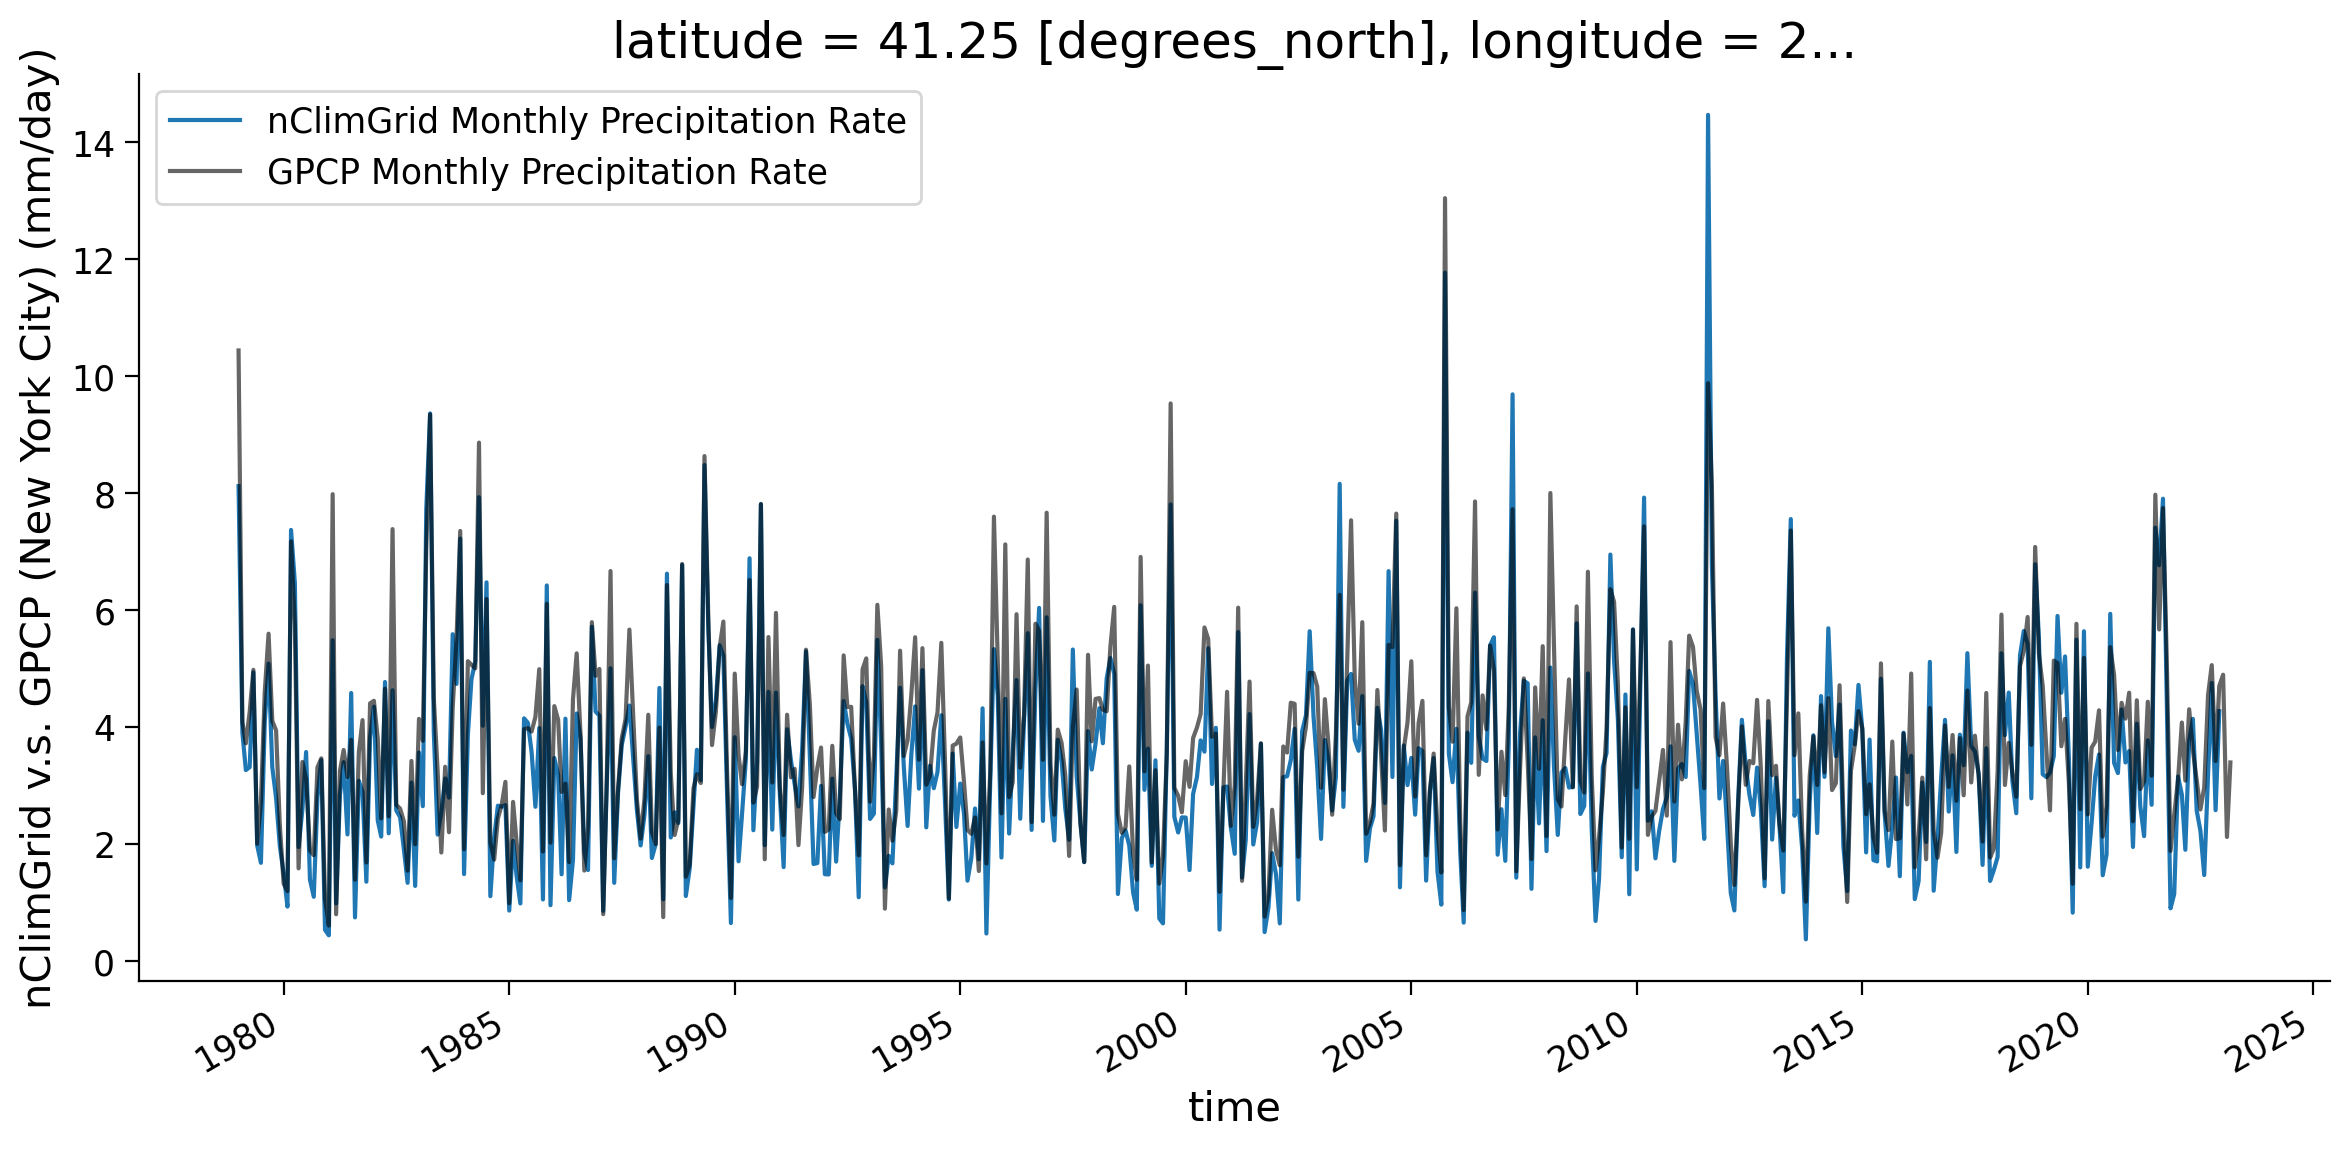

In [15]:
# let's look at the comparison between the precipitation rate from nClimGrid and satellite CDR
fig,ax = plt.subplots(figsize=(12,6))
obs.plot(label='nClimGrid Monthly Precipitation Rate',ax=ax)
sat.plot(color='k', alpha=0.6, label='GPCP Monthly Precipitation Rate',ax=ax)
ax.set_ylabel('nClimGrid v.s. GPCP (New York City) (mm/day)')
ax.legend()

Now we are going to zoom in to a few years to see how the data compares.

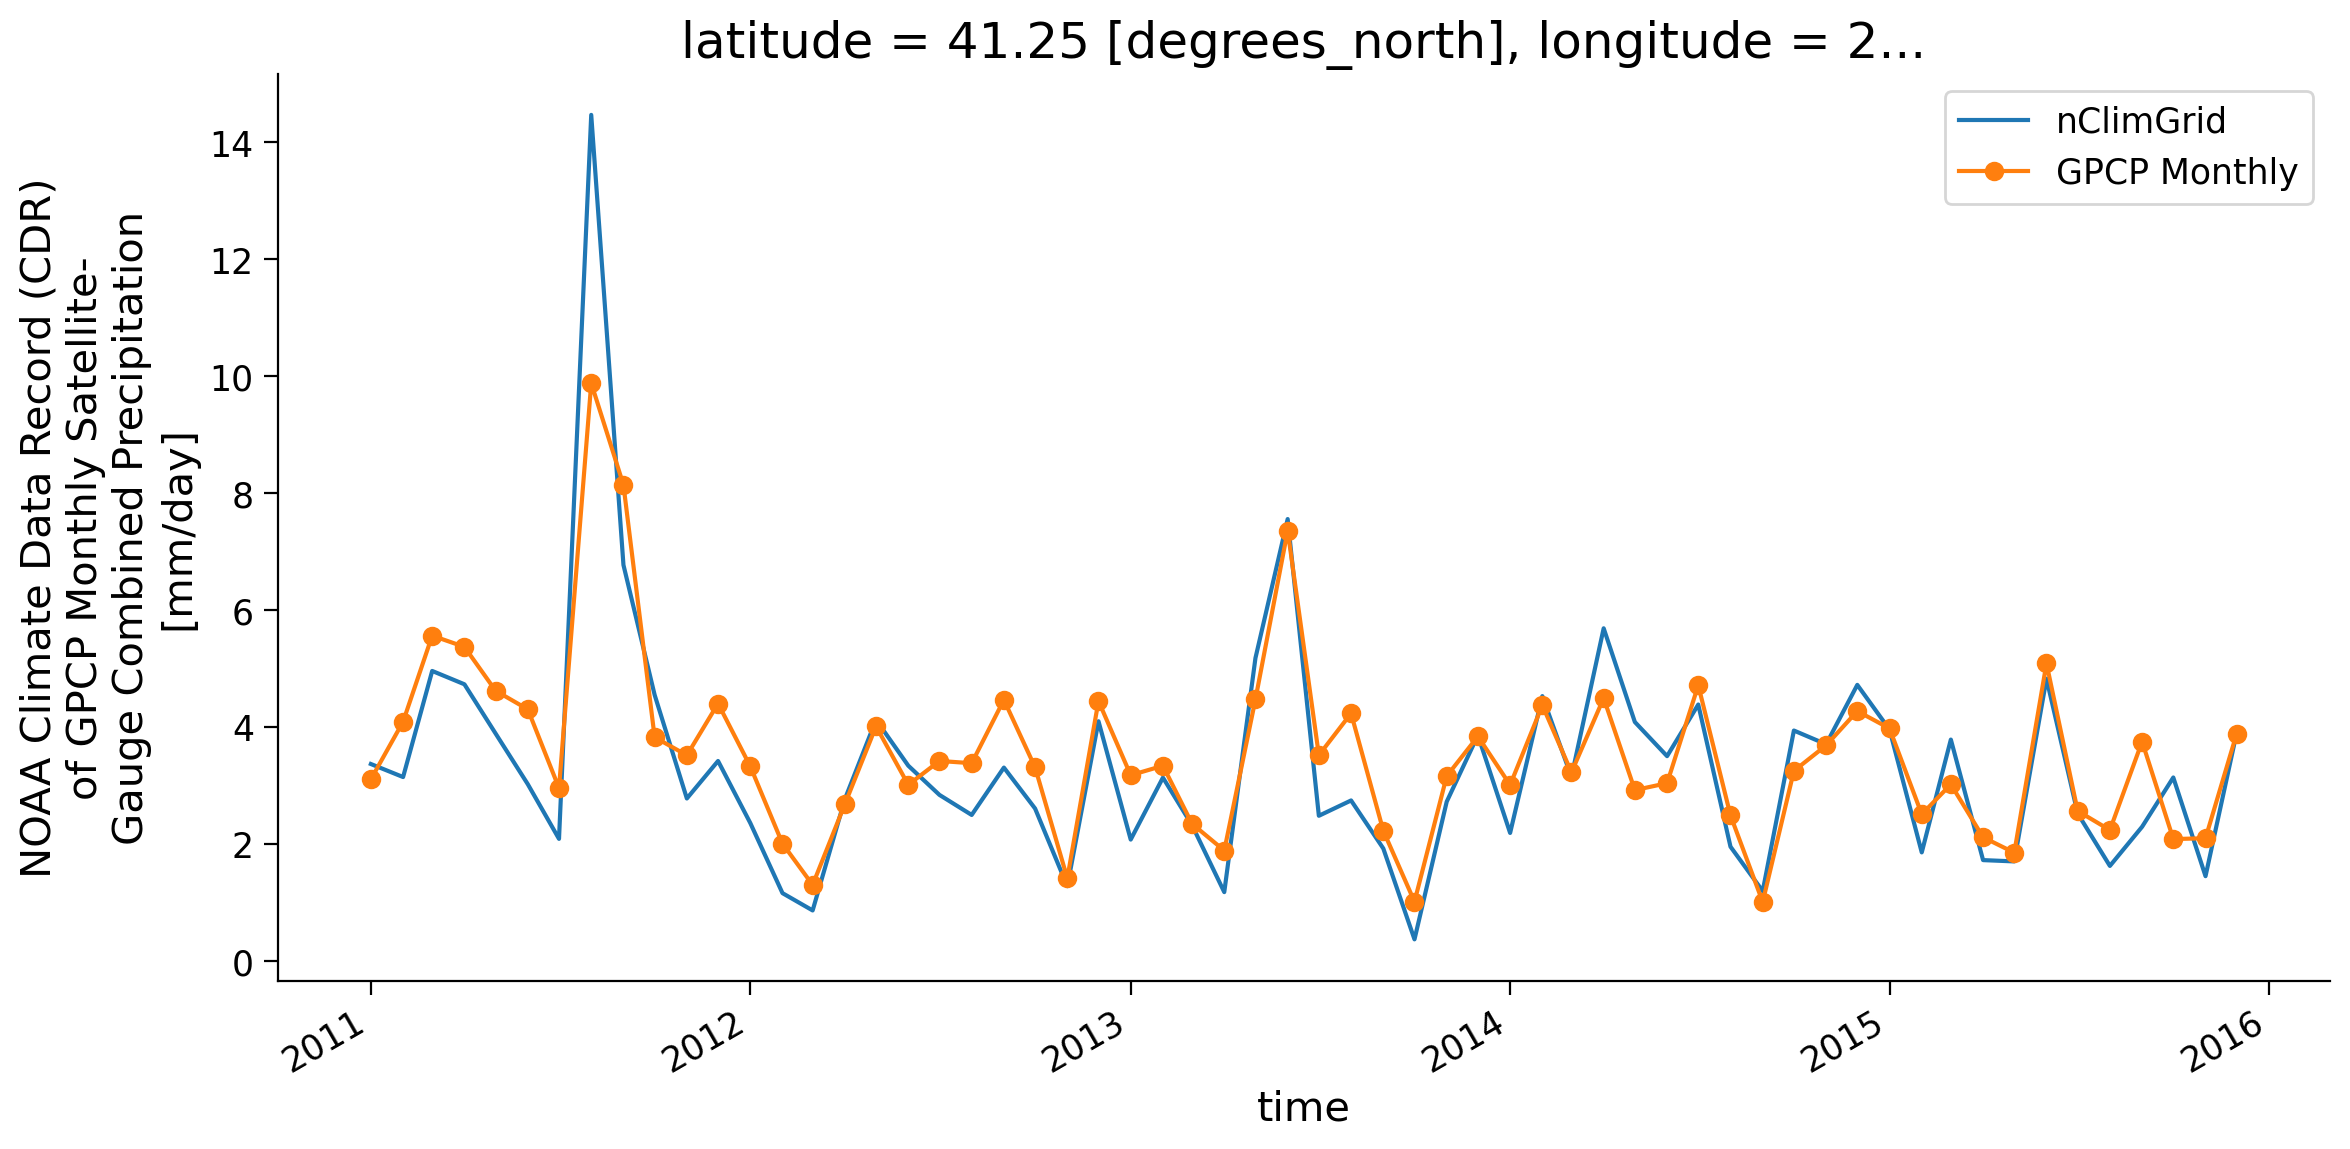

In [16]:
fig,ax = plt.subplots(figsize=(12,6))
obs.sel(time=slice('2011-01-01', '2015-12-01')).plot(label='nClimGrid',ax=ax)
sat.sel(time=slice('2011-01-01', '2015-12-01')).plot(marker='o', label='GPCP Monthly',ax=ax)
ax.legend()

We see a great alignment in the precipitation rate between the nClimGrid and GPCP data when we look at the details over this small chosen window. However, we cannot zoom in to every location for all times to confirm they are a good match. We can use statistics to quantify the relationship between these two datasets for as in a automated fashion, and will do so in the next section.

## **Section 1.5: Quantify the Difference**

One way to more robustly compare the datasets is through a scatterplot. The data would ideally follow the 1:1 line, which would suggest that they are very closely matched. Let's make this plot and observe how our data compares to one another:

In [17]:
# make sure that both observation and satellite data are for the samte time period
sat = sat.sel(time=slice('1979-01-01','2022-12-01'))
obs = obs.sel(time=slice('1979-01-01','2022-12-01'))

Text(0, 0.5, 'nClimGrid (mm/day)')

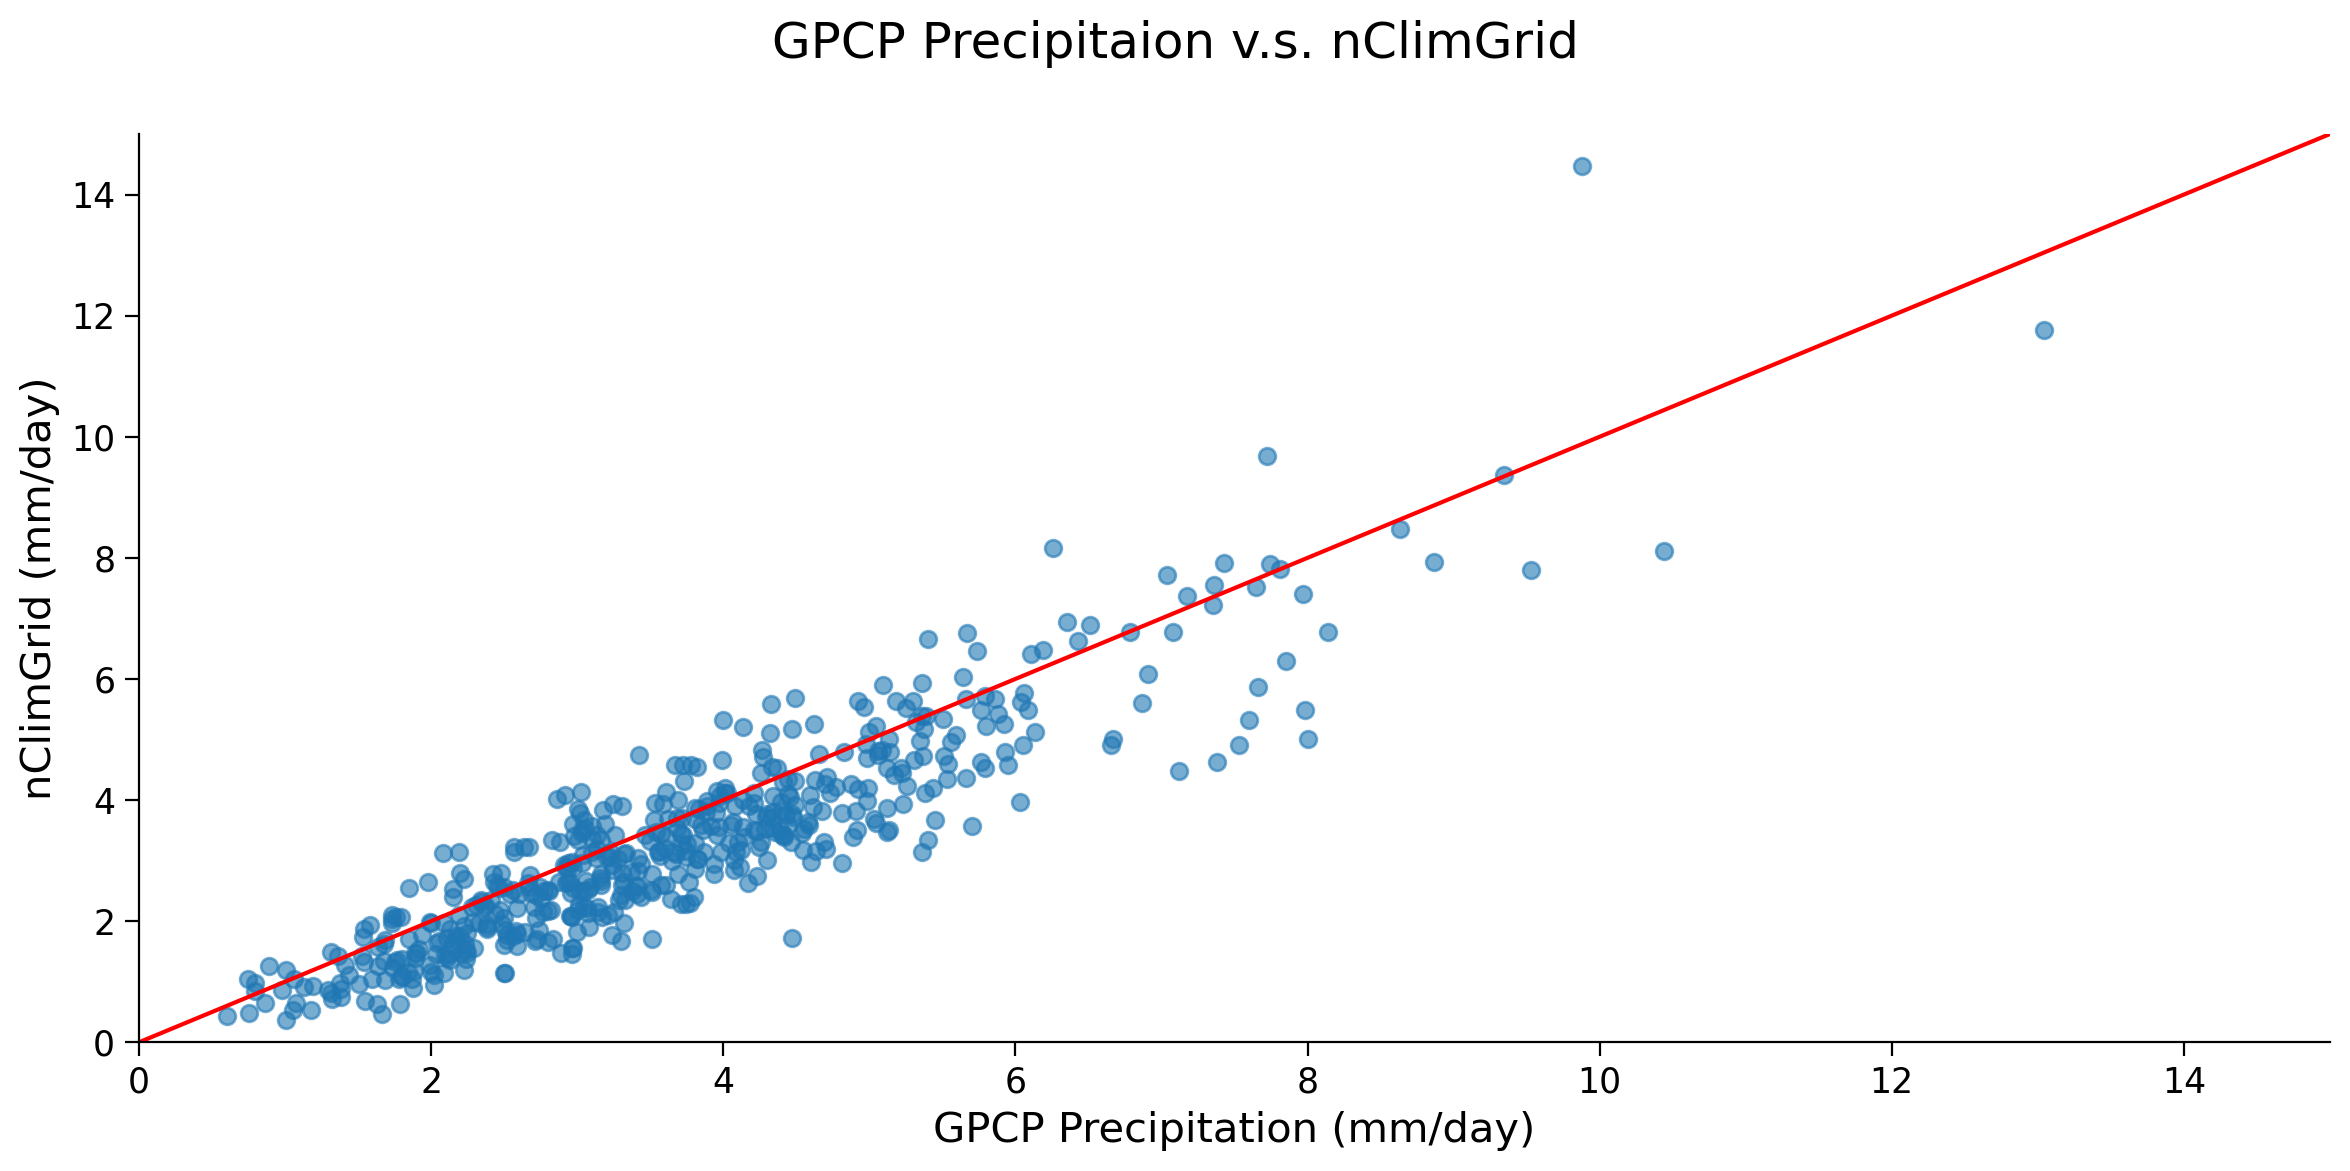

In [20]:
# plot the scatter plot between nClimGrid and GPCP monthly precipitation CDR
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('GPCP Precipitaion v.s. nClimGrid')
ax.scatter(sat, obs, alpha=0.6)
# Add 1:1 line
y_lim = (0,15)
x_lim = (0,15)
ax.plot((0,15), (0,15), 'r-')
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
ax.set_xlabel('GPCP Precipitation (mm/day)')
ax.set_ylabel('nClimGrid (mm/day)')


By eye, there appears to be a stong correlation between the satellite data and the observations for NYC, with much of the data following the 1:1 line plotted in red. As in the last tutorial, we can calculate the correlation coefficient and corresponding p-value.

In [19]:
r,p = stats.pearsonr(sat, obs) 
print('Corr Coef: ' + str(r) + ', p-val: ' + str(p))

Corr Coef: 0.9071623652300999, p-val: 6.866973624866291e-200


As we expected, the data are significantly correlated.

### **Coding Exercises 1.5**

1. Sometimes, we are more interested in the difference among the anomaly data rather than the total data. Using the same location, compare the anomaly data.

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Compare the anomaly of precipitation rate for NYC.")
#################################################

# calculate climatology for the 1981-2010 period for both GPCP and nClimGrid
sat_clim = ...
obs_clim = ...

# calculate anomaly of the NYC time series for both GPCP and nClimGrid
sat_clim_anom = ...
obs_clim_anom = ...

# plot time series and scatter plot between two time series
fig,ax = plt.subplots(figsize=(12, 6))
obs_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(label='nClimGrid anomaly',ax=ax)
sat_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(marker='o', label='GPCP Monthly anomaly',ax=ax)
ax.legend()

# plot the scatter plot between nClimGrid and GPCP monthly precipitation CDR
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('GPCP Precipitaion v.s. nClimGrid')
ax.scatter(sat_clim_anom, obs_clim_anom, alpha=0.6)
# Add 1:1 line
y_lim = (0,15)
x_lim = (0,15)
ax.plot((0,15), (0,15), 'r-')
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
ax.set_xlabel('GPCP Precipitation anomaly (mm/day)')
ax.set_ylabel('nClimGrid anomaly (mm/day)')

# calculate and print correlation coefficient and p-value
r,p = ...
print('Corr Coef: ' + str(r) + ', p-val: ' + str(p))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]


Corr Coef: 0.9124177643192264, p-val: 3.108602048465332e-206


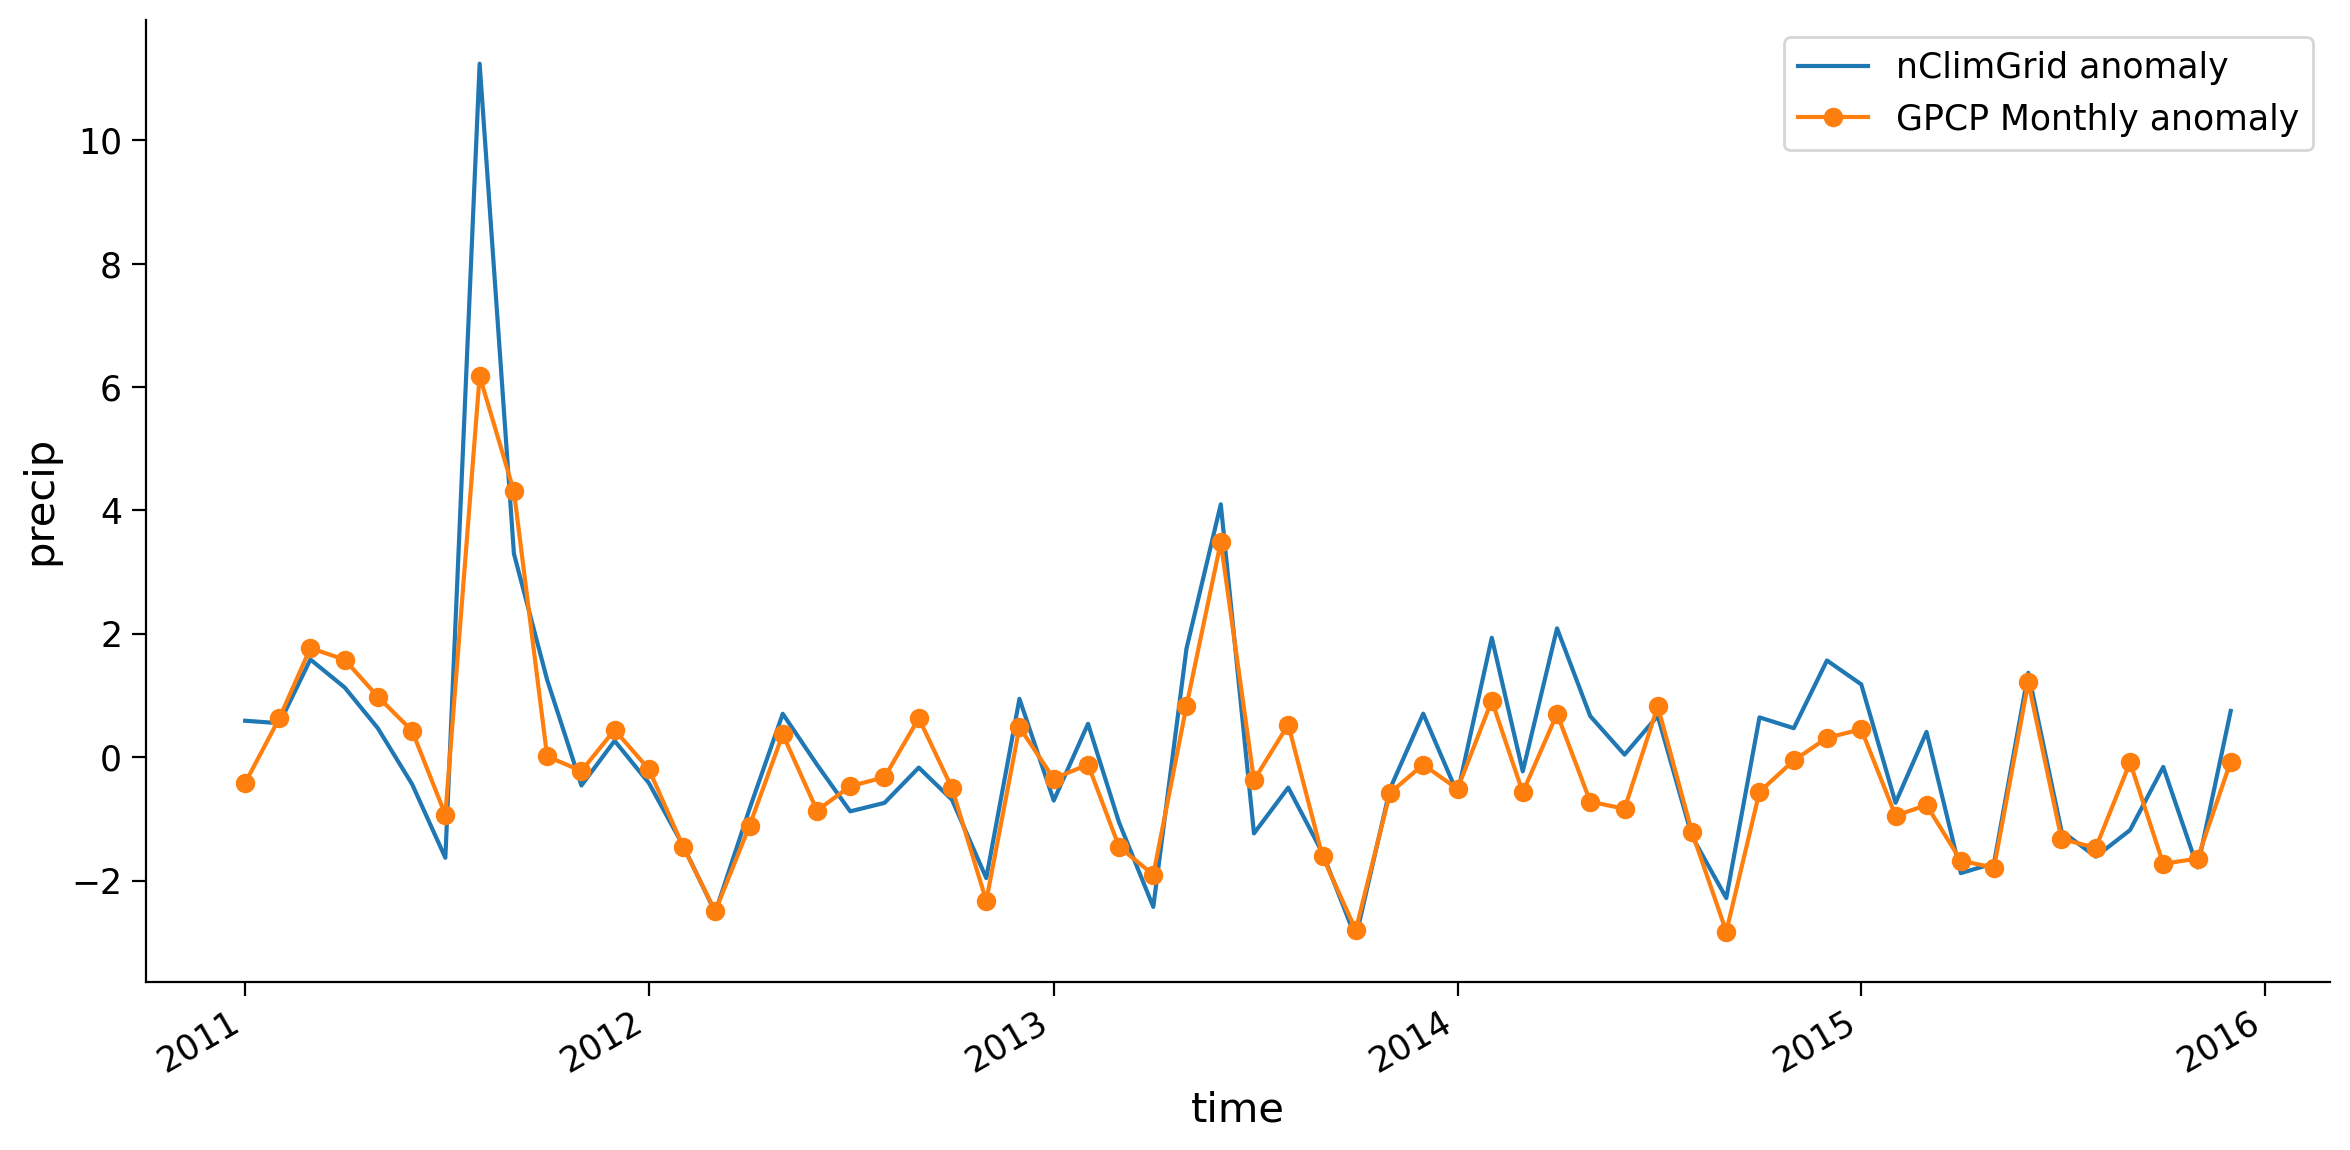

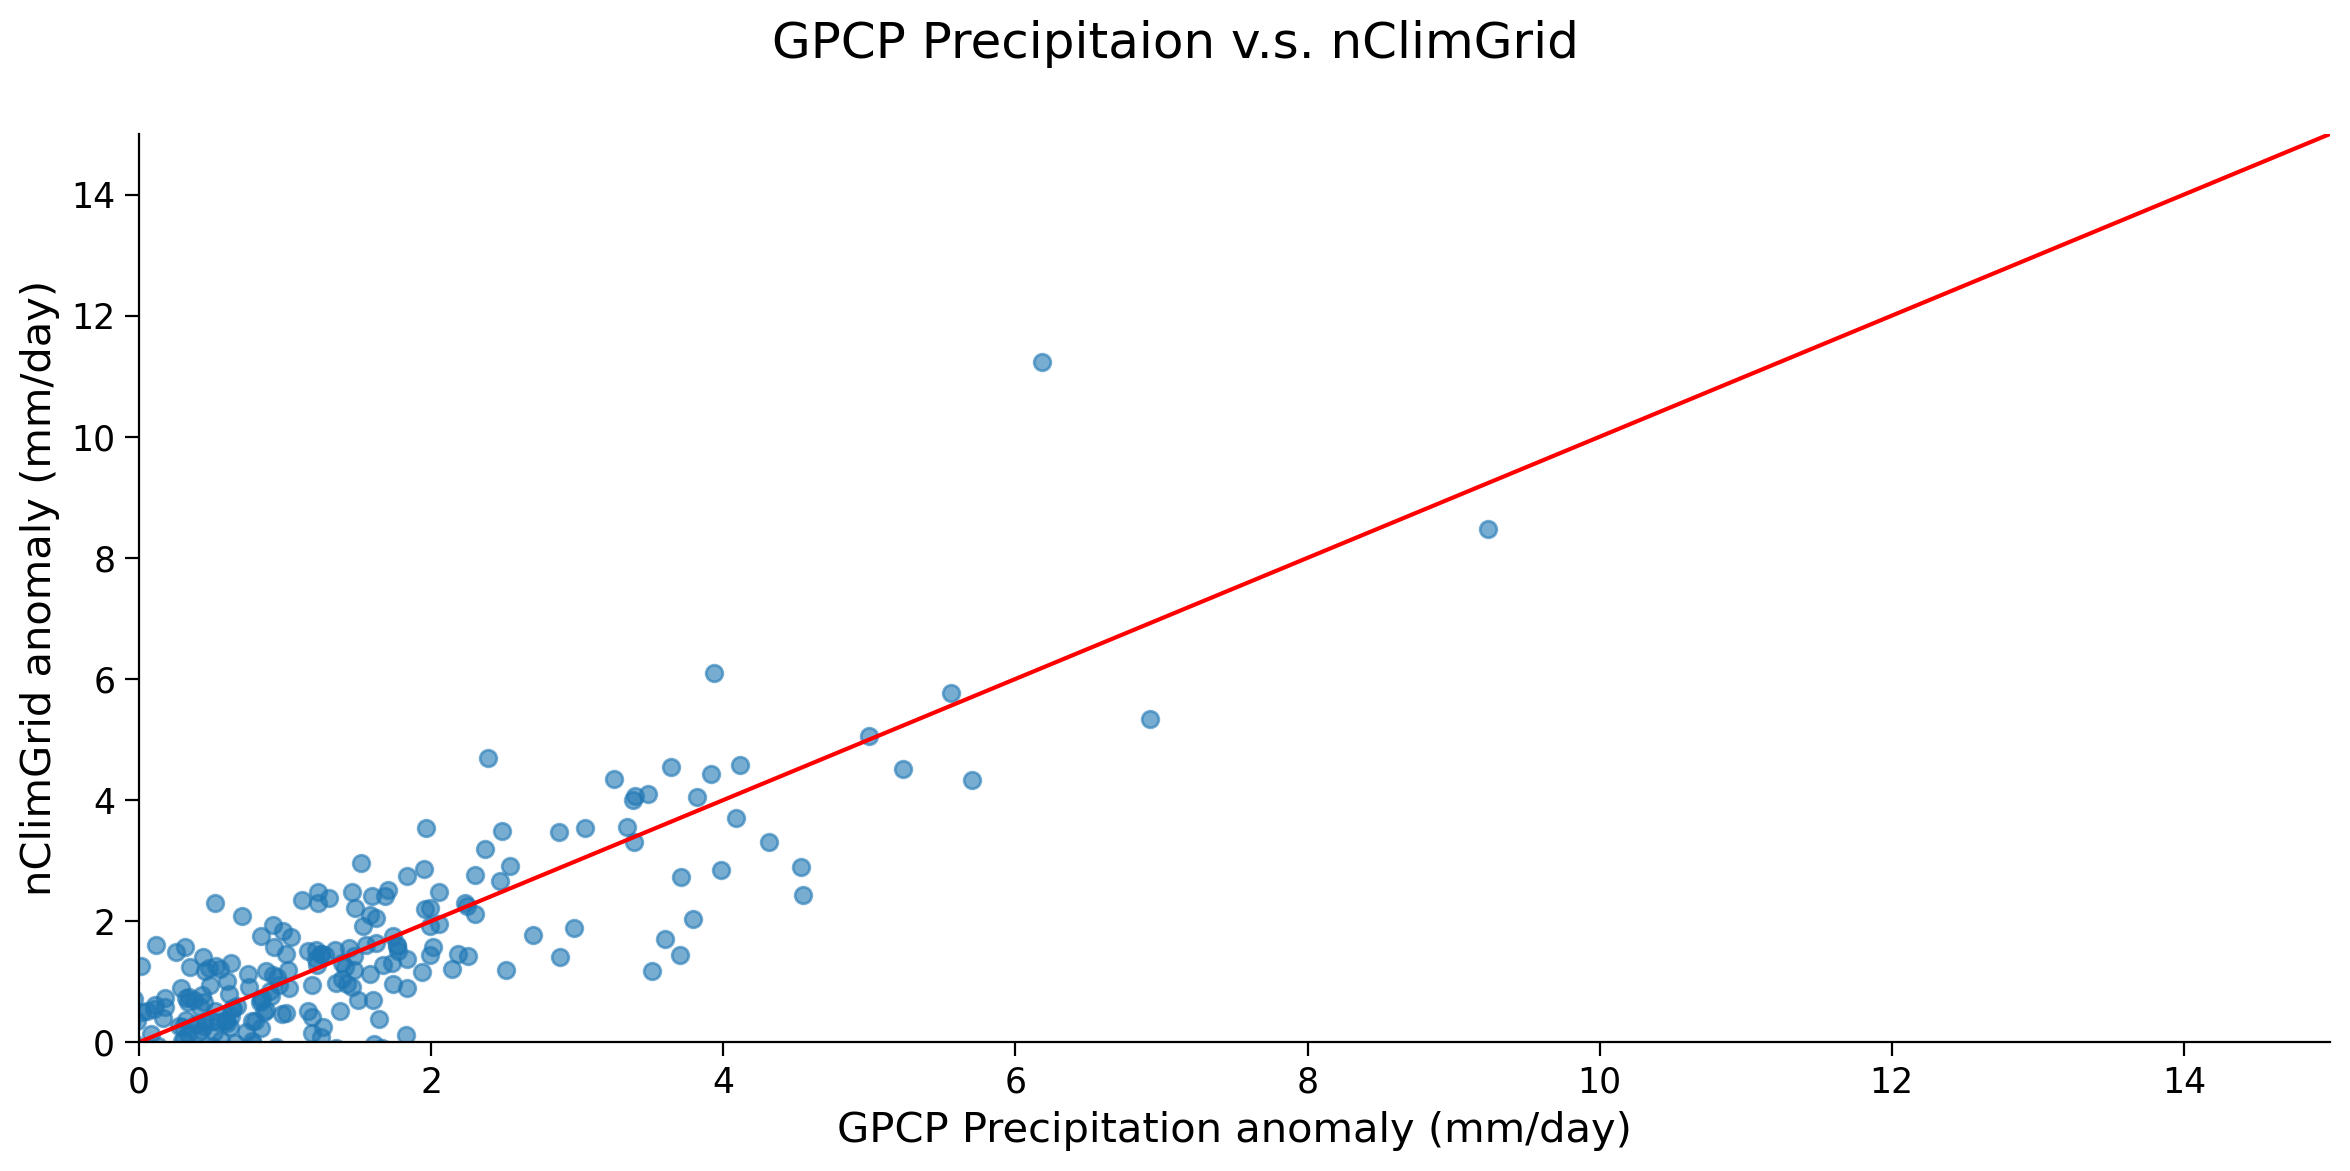

In [22]:
# to_remove solution

# calculate climatology for the 1981-2010 period for both GPCP and nClimGrid
sat_clim = sat.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')
obs_clim = obs.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')

# calculate anomaly of the NYC time series for both GPCP and nClimGrid
sat_clim_anom = sat.groupby('time.month') - sat_clim
obs_clim_anom = obs.groupby('time.month') - obs_clim

# plot time series and scatter plot between two time series
fig,ax = plt.subplots(figsize=(12, 6))
obs_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(label='nClimGrid anomaly',ax=ax)
sat_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(marker='o', label='GPCP Monthly anomaly',ax=ax)
ax.legend()

# plot the scatter plot between nClimGrid and GPCP monthly precipitation CDR
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('GPCP Precipitaion v.s. nClimGrid')
ax.scatter(sat_clim_anom, obs_clim_anom, alpha=0.6)
# Add 1:1 line
y_lim = (0,15)
x_lim = (0,15)
ax.plot((0,15), (0,15), 'r-')
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
ax.set_xlabel('GPCP Precipitation anomaly (mm/day)')
ax.set_ylabel('nClimGrid anomaly (mm/day)')

# calculate and print correlation coefficient and p-value
r,p = stats.pearsonr(sat_clim_anom, obs_clim_anom) 
print('Corr Coef: ' + str(r) + ', p-val: ' + str(p))

# **Summary**

In this tutorial, you explored how to use station-based observations within the U.S. to evaluate satellite precipitation data. While this isn't a global comparison, the methodology can be applied to other station or observation data you may wish to utilize.

When carrying out these comparisons, remember the following key points:

- Ensure that both the satellite data and the observations represent the same quantity (for example, total precipitation amount versus precipitation rate).
- Comparisons should be made for the same geolocation (or very near to it) and the same time period.
- Be aware of potential spatial scale effects. Satellite data measures over a large area, whereas observations may be narrowly focused, particularly for elements that exhibit substantial spatial variability. This can lead to considerable uncertainty in the satellite data.


# Resources

Data from this tutorial can be accessed [here](https://noaa-cdr-precip-gpcp-monthly-pds.s3.amazonaws.com/index.html#data/) and [here](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily).